In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim

import optuna

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc,matthews_corrcoef, precision_recall_curve,roc_auc_score



データ読み取り

In [8]:
df=pd.read_csv('../../data/learning_data.csv',index_col=0)

X=df.drop(columns='dengue',axis=1).values
y=df['dengue'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1,random_state=42)

#torchテンソルに変換
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32)


In [9]:
class DNN_11(nn.Module):
    def __init__(self, input_dim,dropout1,dropout2):
        super(DNN_11, self).__init__()
        self.layer1 = nn.Linear(input_dim,64)
        self.layer2 = nn.Linear(64,32)
        self.layer3 = nn.Linear(32, 16)
        self.layer4 = nn.Linear(16, 8)
        self.output_layer = nn.Linear(8, 1)

        self.dropout1 = nn.Dropout(dropout1)
        self.dropout2 = nn.Dropout(dropout2)
        
    def forward(self, x):
        x = torch.relu(self.layer1(x))
        x = self.dropout1(x)
        
        x = torch.relu(self.layer2(x))
    

        x = torch.relu(self.layer3(x))
        x = self.dropout2(x)

        x = torch.relu(self.layer4(x))
        
        x = torch.sigmoid(self.output_layer(x)) 
        return x
    

学習データセットの作成

In [10]:
train_dataset = torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=4, shuffle=True)

val_dataset = torch.utils.data.TensorDataset(X_val_tensor, y_val_tensor)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset, batch_size=4, shuffle=False)

Optunaの設定

In [11]:
def objective(trial):
    dropout1 = trial.suggest_float("dropout1", 0, 0.5, step=0.05)
    dropout2 = trial.suggest_float("dropout2", 0, 0.5, step=0.05)
    learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)  # 範囲を調整
    weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-2)   # 範囲を調整

    # モデル定義
    model = DNN_11(
        input_dim=X_train_tensor.shape[1],
        dropout1=dropout1,
        dropout2=dropout2
    ).to(device)

    criterion = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

    # Early Stoppingの設定
    patience = 10
    best_val_loss = float('inf')
    patience_counter = 0

    # 訓練ループ
    num_epochs = 100
    for epoch in range(num_epochs):
        model.train()
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            outputs = model(X_batch).squeeze()
            loss = criterion(outputs, y_batch.squeeze())
            loss.backward()
            optimizer.step()

        # バリデーション評価
        model.eval()
        val_loss = 0
        val_true, val_pred = [], []
        with torch.no_grad():
            for X_val, y_val in val_loader:
                X_val, y_val = X_val.to(device), y_val.to(device)
                val_outputs = model(X_val).squeeze()
                val_loss += criterion(val_outputs, y_val.squeeze()).item()
                predictions = (val_outputs >0.49).float()
                val_true.extend(y_val.cpu().numpy())
                val_pred.extend(predictions.cpu().numpy())

        val_loss /= len(val_loader)

        # Early Stoppingの判定
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch}")
            break

        # Optunaへのログ
        trial.report(val_loss, epoch)
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

    # 評価指標の計算
    mcc = matthews_corrcoef(val_true, val_pred)
    print(f"Final MCC: {mcc:.4f}")

    return mcc  # mccを返す


In [12]:
device_id = 0  # 使用するGPUのID（0または1）
torch.cuda.set_device(device_id)
device = torch.device(f"cuda:{device_id}" if torch.cuda.is_available() else "cpu")

# Optunaの設定
study = optuna.create_study(direction="maximize")  
study.optimize(objective, n_trials=100)

# 結果表示
print("Best Parameters: ", study.best_params)
print("Best Validation F1: ", study.best_value)

[I 2024-12-04 16:16:41,844] A new study created in memory with name: no-name-0350f33a-020b-4b31-96ec-4b5f73f3bc4f
/tmp/ipykernel_282819/3985275715.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)  # 範囲を調整
/tmp/ipykernel_282819/3985275715.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-2)   # 範囲を調整
[I 2024-12-04 16:18:22,810] Trial 0 finished with value: 0.2836753544113046 and parameters: {'dropout1': 0.45, 'dropout2': 0.45, 'learning_rate': 0.0005197351839045986, 'weight_decay': 6.370401689405554e-05}. Best is trial 0 with value: 

Early stopping at epoch 32
Final MCC: 0.2837


/tmp/ipykernel_282819/3985275715.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)  # 範囲を調整
/tmp/ipykernel_282819/3985275715.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-2)   # 範囲を調整
[I 2024-12-04 16:20:16,484] Trial 1 finished with value: 0.16972115902951374 and parameters: {'dropout1': 0.25, 'dropout2': 0.30000000000000004, 'learning_rate': 0.00020676254728346232, 'weight_decay': 4.1600000655020575e-05}. Best is trial 0 with value: 0.2836753544113046.


Early stopping at epoch 33
Final MCC: 0.1697


/tmp/ipykernel_282819/3985275715.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)  # 範囲を調整
/tmp/ipykernel_282819/3985275715.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-2)   # 範囲を調整
[I 2024-12-04 16:21:28,010] Trial 2 finished with value: 0.0 and parameters: {'dropout1': 0.05, 'dropout2': 0.4, 'learning_rate': 0.007640352399436785, 'weight_decay': 2.9399341530123685e-05}. Best is trial 0 with value: 0.2836753544113046.


Early stopping at epoch 20
Final MCC: 0.0000


/tmp/ipykernel_282819/3985275715.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)  # 範囲を調整
/tmp/ipykernel_282819/3985275715.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-2)   # 範囲を調整
[I 2024-12-04 16:24:46,011] Trial 3 finished with value: 0.2509980079602227 and parameters: {'dropout1': 0.5, 'dropout2': 0.05, 'learning_rate': 0.00010738655753356603, 'weight_decay': 5.334453393059997e-05}. Best is trial 0 with value: 0.2836753544113046.


Early stopping at epoch 58
Final MCC: 0.2510


/tmp/ipykernel_282819/3985275715.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)  # 範囲を調整
/tmp/ipykernel_282819/3985275715.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-2)   # 範囲を調整
[I 2024-12-04 16:26:39,082] Trial 4 finished with value: 0.20406354279751285 and parameters: {'dropout1': 0.15000000000000002, 'dropout2': 0.1, 'learning_rate': 0.0001956896993488602, 'weight_decay': 1.2510335051134339e-05}. Best is trial 0 with value: 0.2836753544113046.


Early stopping at epoch 32
Final MCC: 0.2041


/tmp/ipykernel_282819/3985275715.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)  # 範囲を調整
/tmp/ipykernel_282819/3985275715.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-2)   # 範囲を調整
[I 2024-12-04 16:26:42,402] Trial 5 pruned. 
[I 2024-12-04 16:26:45,734] Trial 6 pruned. 
[I 2024-12-04 16:28:27,163] Trial 7 finished with value: 0.29423919957760236 and parameters: {'dropout1': 0.35000000000000003, 'dropout2': 0.25, 'learning_rate': 0.00030505229147318683, 'weight_decay': 7.97971038070116e-05}. Best is trial 7 with value: 0.294239

Early stopping at epoch 29
Final MCC: 0.2942


/tmp/ipykernel_282819/3985275715.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)  # 範囲を調整
/tmp/ipykernel_282819/3985275715.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-2)   # 範囲を調整
[I 2024-12-04 16:28:30,577] Trial 8 pruned. 
[I 2024-12-04 16:30:40,667] Trial 9 finished with value: 0.2269285812025616 and parameters: {'dropout1': 0.30000000000000004, 'dropout2': 0.4, 'learning_rate': 0.00014254226269769487, 'weight_decay': 3.004088160791244e-05}. Best is trial 7 with value: 0.29423919957760236.


Early stopping at epoch 36
Final MCC: 0.2269


/tmp/ipykernel_282819/3985275715.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)  # 範囲を調整
/tmp/ipykernel_282819/3985275715.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-2)   # 範囲を調整
[I 2024-12-04 16:30:43,991] Trial 10 pruned. 
[I 2024-12-04 16:30:47,275] Trial 11 pruned. 
[I 2024-12-04 16:30:50,561] Trial 12 pruned. 
[I 2024-12-04 16:30:53,792] Trial 13 pruned. 
[I 2024-12-04 16:30:57,367] Trial 14 pruned. 
[I 2024-12-04 16:31:00,932] Trial 15 pruned. 
[I 2024-12-04 16:31:04,448] Trial 16 pruned. 
[I 2024-12-04 16:31:07,997] T

Early stopping at epoch 97
Final MCC: 0.1909


/tmp/ipykernel_282819/3985275715.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)  # 範囲を調整
/tmp/ipykernel_282819/3985275715.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-2)   # 範囲を調整
[I 2024-12-04 16:40:56,119] Trial 22 finished with value: 0.32011378178572664 and parameters: {'dropout1': 0.5, 'dropout2': 0.0, 'learning_rate': 0.0001005942050644682, 'weight_decay': 2.1395042645226615e-05}. Best is trial 22 with value: 0.32011378178572664.


Early stopping at epoch 61
Final MCC: 0.3201


/tmp/ipykernel_282819/3985275715.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)  # 範囲を調整
/tmp/ipykernel_282819/3985275715.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-2)   # 範囲を調整
[I 2024-12-04 16:40:59,822] Trial 23 pruned. 
[I 2024-12-04 16:41:03,536] Trial 24 pruned. 
[I 2024-12-04 16:41:07,243] Trial 25 pruned. 
[I 2024-12-04 16:41:10,877] Trial 26 pruned. 
[I 2024-12-04 16:41:14,506] Trial 27 pruned. 
[I 2024-12-04 16:43:51,351] Trial 28 finished with value: 0.2931986751476211 and parameters: {'dropout1': 0.3000000000000

Early stopping at epoch 42
Final MCC: 0.2932


/tmp/ipykernel_282819/3985275715.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)  # 範囲を調整
/tmp/ipykernel_282819/3985275715.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-2)   # 範囲を調整
[I 2024-12-04 16:48:13,365] Trial 29 finished with value: 0.20008756547232942 and parameters: {'dropout1': 0.25, 'dropout2': 0.1, 'learning_rate': 0.00010111989555254775, 'weight_decay': 3.528611639658363e-05}. Best is trial 22 with value: 0.32011378178572664.


Early stopping at epoch 71
Final MCC: 0.2001


/tmp/ipykernel_282819/3985275715.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)  # 範囲を調整
/tmp/ipykernel_282819/3985275715.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-2)   # 範囲を調整
[I 2024-12-04 16:48:16,990] Trial 30 pruned. 
[I 2024-12-04 16:48:20,587] Trial 31 pruned. 
[I 2024-12-04 16:48:24,162] Trial 32 pruned. 
[I 2024-12-04 16:53:51,554] Trial 33 finished with value: 0.22245099695814544 and parameters: {'dropout1': 0.45, 'dropout2': 0.30000000000000004, 'learning_rate': 0.00011071422622615461, 'weight_decay': 3.75164311

Early stopping at epoch 87
Final MCC: 0.2225


/tmp/ipykernel_282819/3985275715.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)  # 範囲を調整
/tmp/ipykernel_282819/3985275715.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-2)   # 範囲を調整
[I 2024-12-04 16:53:55,386] Trial 34 pruned. 
[I 2024-12-04 16:53:59,278] Trial 35 pruned. 
[I 2024-12-04 16:54:03,142] Trial 36 pruned. 
[I 2024-12-04 16:56:46,729] Trial 37 finished with value: 0.3353661536031184 and parameters: {'dropout1': 0.5, 'dropout2': 0.1, 'learning_rate': 0.0001275979205551097, 'weight_decay': 0.00022304552639324245}. Best

Early stopping at epoch 43
Final MCC: 0.3354


/tmp/ipykernel_282819/3985275715.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)  # 範囲を調整
/tmp/ipykernel_282819/3985275715.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-2)   # 範囲を調整
[I 2024-12-04 16:59:46,274] Trial 38 finished with value: 0.27046567320214226 and parameters: {'dropout1': 0.5, 'dropout2': 0.1, 'learning_rate': 0.00011736199221267189, 'weight_decay': 0.000244142802275088}. Best is trial 37 with value: 0.3353661536031184.


Early stopping at epoch 47
Final MCC: 0.2705


/tmp/ipykernel_282819/3985275715.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)  # 範囲を調整
/tmp/ipykernel_282819/3985275715.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-2)   # 範囲を調整
[I 2024-12-04 16:59:49,997] Trial 39 pruned. 
[I 2024-12-04 16:59:53,672] Trial 40 pruned. 
[I 2024-12-04 16:59:57,310] Trial 41 pruned. 
[I 2024-12-04 17:00:00,956] Trial 42 pruned. 
[I 2024-12-04 17:00:04,671] Trial 43 pruned. 
[I 2024-12-04 17:00:08,505] Trial 44 pruned. 
[I 2024-12-04 17:00:12,267] Trial 45 pruned. 
[I 2024-12-04 17:00:16,030] T

Early stopping at epoch 48
Final MCC: 0.3187


/tmp/ipykernel_282819/3985275715.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)  # 範囲を調整
/tmp/ipykernel_282819/3985275715.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-2)   # 範囲を調整
[I 2024-12-04 17:07:46,990] Trial 53 finished with value: 0.24984639863794986 and parameters: {'dropout1': 0.45, 'dropout2': 0.15000000000000002, 'learning_rate': 0.00013280192880712728, 'weight_decay': 0.0004743354985614693}. Best is trial 37 with value: 0.3353661536031184.


Early stopping at epoch 64
Final MCC: 0.2498


/tmp/ipykernel_282819/3985275715.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)  # 範囲を調整
/tmp/ipykernel_282819/3985275715.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-2)   # 範囲を調整
[I 2024-12-04 17:07:50,804] Trial 54 pruned. 
[I 2024-12-04 17:07:54,649] Trial 55 pruned. 
[I 2024-12-04 17:11:09,622] Trial 56 finished with value: 0.26442040376745435 and parameters: {'dropout1': 0.5, 'dropout2': 0.35000000000000003, 'learning_rate': 0.00012684567418183535, 'weight_decay': 0.0012800413794786952}. Best is trial 37 with value: 0.33

Early stopping at epoch 55
Final MCC: 0.2644


/tmp/ipykernel_282819/3985275715.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)  # 範囲を調整
/tmp/ipykernel_282819/3985275715.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-2)   # 範囲を調整
[I 2024-12-04 17:11:13,059] Trial 57 pruned. 
[I 2024-12-04 17:11:16,427] Trial 58 pruned. 
[I 2024-12-04 17:11:19,832] Trial 59 pruned. 
[I 2024-12-04 17:11:23,261] Trial 60 pruned. 
[I 2024-12-04 17:14:28,845] Trial 61 finished with value: 0.2491270510681658 and parameters: {'dropout1': 0.5, 'dropout2': 0.1, 'learning_rate': 0.00011705716816055344

Early stopping at epoch 53
Final MCC: 0.2491


/tmp/ipykernel_282819/3985275715.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)  # 範囲を調整
/tmp/ipykernel_282819/3985275715.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-2)   # 範囲を調整
[I 2024-12-04 17:14:31,993] Trial 62 pruned. 
[I 2024-12-04 17:16:59,827] Trial 63 finished with value: 0.3182192318053801 and parameters: {'dropout1': 0.5, 'dropout2': 0.5, 'learning_rate': 0.00012648308539607144, 'weight_decay': 0.00020274981158354842}. Best is trial 37 with value: 0.3353661536031184.


Early stopping at epoch 47
Final MCC: 0.3182


/tmp/ipykernel_282819/3985275715.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)  # 範囲を調整
/tmp/ipykernel_282819/3985275715.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-2)   # 範囲を調整
[I 2024-12-04 17:17:02,933] Trial 64 pruned. 
[I 2024-12-04 17:21:13,343] Trial 65 finished with value: 0.23845453358054547 and parameters: {'dropout1': 0.5, 'dropout2': 0.5, 'learning_rate': 0.00012126941960010696, 'weight_decay': 0.0003906895038721879}. Best is trial 37 with value: 0.3353661536031184.


Early stopping at epoch 80
Final MCC: 0.2385


/tmp/ipykernel_282819/3985275715.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)  # 範囲を調整
/tmp/ipykernel_282819/3985275715.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-2)   # 範囲を調整
[I 2024-12-04 17:21:16,491] Trial 66 pruned. 
[I 2024-12-04 17:21:19,597] Trial 67 pruned. 
[I 2024-12-04 17:21:22,718] Trial 68 pruned. 
[I 2024-12-04 17:21:25,833] Trial 69 pruned. 
[I 2024-12-04 17:21:28,918] Trial 70 pruned. 
[I 2024-12-04 17:21:32,052] Trial 71 pruned. 
[I 2024-12-04 17:24:16,090] Trial 72 finished with value: 0.255129270974033

Early stopping at epoch 52
Final MCC: 0.2551


/tmp/ipykernel_282819/3985275715.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)  # 範囲を調整
/tmp/ipykernel_282819/3985275715.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-2)   # 範囲を調整
[I 2024-12-04 17:26:07,119] Trial 73 finished with value: 0.20015740459784206 and parameters: {'dropout1': 0.05, 'dropout2': 0.15000000000000002, 'learning_rate': 0.00010897570948049016, 'weight_decay': 0.00019768961050708035}. Best is trial 37 with value: 0.3353661536031184.


Early stopping at epoch 35
Final MCC: 0.2002


/tmp/ipykernel_282819/3985275715.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)  # 範囲を調整
/tmp/ipykernel_282819/3985275715.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-2)   # 範囲を調整
[I 2024-12-04 17:26:10,254] Trial 74 pruned. 
[I 2024-12-04 17:26:13,426] Trial 75 pruned. 
[I 2024-12-04 17:27:37,522] Trial 76 finished with value: 0.3238620405592368 and parameters: {'dropout1': 0.5, 'dropout2': 0.5, 'learning_rate': 0.0001887002855799787, 'weight_decay': 8.341256615179761e-05}. Best is trial 37 with value: 0.3353661536031184.


Early stopping at epoch 26
Final MCC: 0.3239


/tmp/ipykernel_282819/3985275715.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)  # 範囲を調整
/tmp/ipykernel_282819/3985275715.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-2)   # 範囲を調整
[I 2024-12-04 17:27:40,701] Trial 77 pruned. 
[I 2024-12-04 17:27:43,874] Trial 78 pruned. 
[I 2024-12-04 17:27:47,083] Trial 79 pruned. 
[I 2024-12-04 17:27:50,275] Trial 80 pruned. 
[I 2024-12-04 17:30:00,045] Trial 81 finished with value: 0.1061707603520985 and parameters: {'dropout1': 0.5, 'dropout2': 0.5, 'learning_rate': 0.0001020426231179225,

Early stopping at epoch 40
Final MCC: 0.1062


/tmp/ipykernel_282819/3985275715.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)  # 範囲を調整
/tmp/ipykernel_282819/3985275715.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-2)   # 範囲を調整
[I 2024-12-04 17:30:03,238] Trial 82 pruned. 
[I 2024-12-04 17:30:06,427] Trial 83 pruned. 
[I 2024-12-04 17:30:09,605] Trial 84 pruned. 
[I 2024-12-04 17:35:12,890] Trial 85 finished with value: 0.19538712238500955 and parameters: {'dropout1': 0.5, 'dropout2': 0.1, 'learning_rate': 0.00010005872349359527, 'weight_decay': 0.005196721370609321}. Best

Final MCC: 0.1954


/tmp/ipykernel_282819/3985275715.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)  # 範囲を調整
/tmp/ipykernel_282819/3985275715.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-2)   # 範囲を調整
[I 2024-12-04 17:35:15,824] Trial 86 pruned. 
[I 2024-12-04 17:35:18,793] Trial 87 pruned. 
[I 2024-12-04 17:35:21,694] Trial 88 pruned. 
[I 2024-12-04 17:35:24,615] Trial 89 pruned. 
[I 2024-12-04 17:37:53,879] Trial 90 finished with value: 0.3156692237509533 and parameters: {'dropout1': 0.5, 'dropout2': 0.5, 'learning_rate': 0.0001630879399140022,

Early stopping at epoch 52
Final MCC: 0.3157


/tmp/ipykernel_282819/3985275715.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)  # 範囲を調整
/tmp/ipykernel_282819/3985275715.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-2)   # 範囲を調整
[I 2024-12-04 17:39:33,647] Trial 91 finished with value: 0.30128712690732123 and parameters: {'dropout1': 0.5, 'dropout2': 0.5, 'learning_rate': 0.0001406870570275937, 'weight_decay': 0.00033937910527191435}. Best is trial 37 with value: 0.3353661536031184.


Early stopping at epoch 34
Final MCC: 0.3013


/tmp/ipykernel_282819/3985275715.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)  # 範囲を調整
/tmp/ipykernel_282819/3985275715.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-2)   # 範囲を調整
[I 2024-12-04 17:39:36,566] Trial 92 pruned. 
[I 2024-12-04 17:39:39,477] Trial 93 pruned. 
[I 2024-12-04 17:39:42,260] Trial 94 pruned. 
[I 2024-12-04 17:42:17,971] Trial 95 finished with value: 0.3058656435219968 and parameters: {'dropout1': 0.45, 'dropout2': 0.45, 'learning_rate': 0.00015865182219129584, 'weight_decay': 0.0008945580166608263}. Be

Early stopping at epoch 53
Final MCC: 0.3059


/tmp/ipykernel_282819/3985275715.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)  # 範囲を調整
/tmp/ipykernel_282819/3985275715.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-2)   # 範囲を調整
[I 2024-12-04 17:42:20,942] Trial 96 pruned. 
[I 2024-12-04 17:44:28,626] Trial 97 finished with value: 0.3089056477310863 and parameters: {'dropout1': 0.5, 'dropout2': 0.5, 'learning_rate': 0.00013099931025142825, 'weight_decay': 0.0005366950222405844}. Best is trial 37 with value: 0.3353661536031184.


Early stopping at epoch 44
Final MCC: 0.3089


/tmp/ipykernel_282819/3985275715.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)  # 範囲を調整
/tmp/ipykernel_282819/3985275715.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-2)   # 範囲を調整
[I 2024-12-04 17:46:59,301] Trial 98 finished with value: 0.32574704291377815 and parameters: {'dropout1': 0.5, 'dropout2': 0.5, 'learning_rate': 0.00015338764733883648, 'weight_decay': 0.0008056850581709616}. Best is trial 37 with value: 0.3353661536031184.


Early stopping at epoch 53
Final MCC: 0.3257


/tmp/ipykernel_282819/3985275715.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)  # 範囲を調整
/tmp/ipykernel_282819/3985275715.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-2)   # 範囲を調整
[I 2024-12-04 17:47:02,178] Trial 99 pruned. 


Best Parameters:  {'dropout1': 0.5, 'dropout2': 0.1, 'learning_rate': 0.0001275979205551097, 'weight_decay': 0.00022304552639324245}
Best Validation F1:  0.3353661536031184


Epoch [1/100], Loss: 0.6697
Epoch [1/100], Train Loss: 0.6697, Val Loss: 0.6405
Epoch [2/100], Loss: 0.6202
Epoch [2/100], Train Loss: 0.6202, Val Loss: 0.5851
Epoch [3/100], Loss: 0.5885
Epoch [3/100], Train Loss: 0.5885, Val Loss: 0.5799
Epoch [4/100], Loss: 0.5846
Epoch [4/100], Train Loss: 0.5846, Val Loss: 0.5798
Epoch [5/100], Loss: 0.5788
Epoch [5/100], Train Loss: 0.5788, Val Loss: 0.5785
Epoch [6/100], Loss: 0.5769
Epoch [6/100], Train Loss: 0.5769, Val Loss: 0.5767
Epoch [7/100], Loss: 0.5739
Epoch [7/100], Train Loss: 0.5739, Val Loss: 0.5756
Epoch [8/100], Loss: 0.5713
Epoch [8/100], Train Loss: 0.5713, Val Loss: 0.5738
Epoch [9/100], Loss: 0.5680
Epoch [9/100], Train Loss: 0.5680, Val Loss: 0.5721
Epoch [10/100], Loss: 0.5696
Epoch [10/100], Train Loss: 0.5696, Val Loss: 0.5707
Epoch [11/100], Loss: 0.5696
Epoch [11/100], Train Loss: 0.5696, Val Loss: 0.5691
Epoch [12/100], Loss: 0.5679
Epoch [12/100], Train Loss: 0.5679, Val Loss: 0.5687
Epoch [13/100], Loss: 0.5634
Epoch

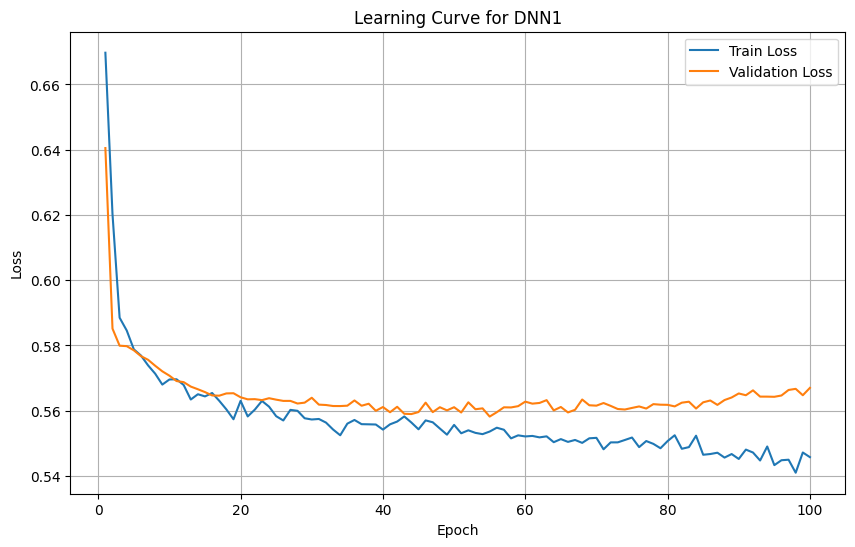

In [13]:
best_params=study.best_params
model = DNN_11(input_dim=X_train_tensor.shape[1],
              dropout1=best_params["dropout1"],
              dropout2=best_params["dropout2"],).to(device)
# 最適化と訓練を実行
optimizer = optim.Adam(model.parameters(), lr=best_params["learning_rate"],weight_decay=best_params["weight_decay"])
criterion = nn.BCELoss()

num_epochs=100
train_losses = []
val_losses = []

model.train()
for epoch in range(num_epochs):
    epoch_train_loss = 0
    epoch_val_loss = 0

    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        outputs = model(X_batch).squeeze()
        loss = criterion(outputs, y_batch.squeeze())
        loss.backward()
        optimizer.step()
        epoch_train_loss += loss.item()
    avg_train_loss = epoch_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_train_loss:.4f}')

    if val_loader is not None:
        model.eval()  
        with torch.no_grad():
            for X_val, y_val in val_loader:
                X_val, y_val = X_val.to(device), y_val.to(device)
                val_outputs = model(X_val).squeeze()
                val_loss = criterion(val_outputs, y_val.squeeze())
                epoch_val_loss += val_loss.item()

        avg_val_loss = epoch_val_loss / len(val_loader)
        val_losses.append(avg_val_loss)
        model.train()  

    if val_loader is not None:
        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")
    else:
        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}")

plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
if val_losses:
    plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Learning Curve for DNN1')
plt.legend()
plt.grid()
plt.show()

Accuracy: 58.20%
Precision: 0.4720
Recall: 0.6962
F1 Score: 0.5626
Matthews Correlation Coefficient: 0.2029
Specificity: 0.5102


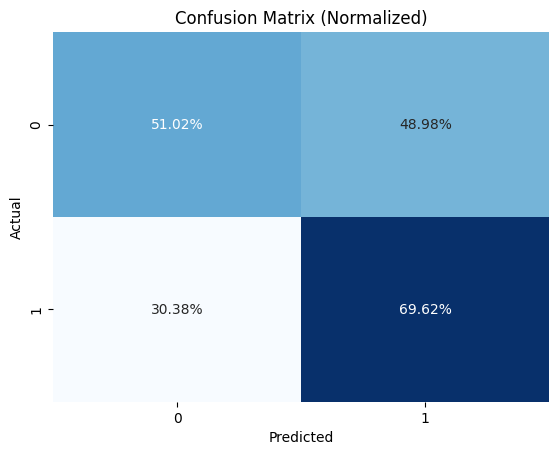

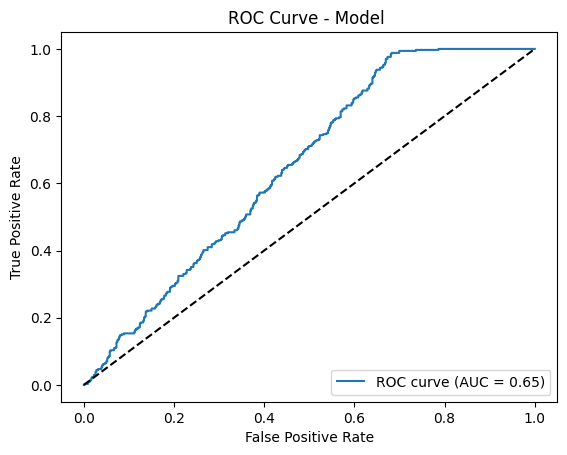

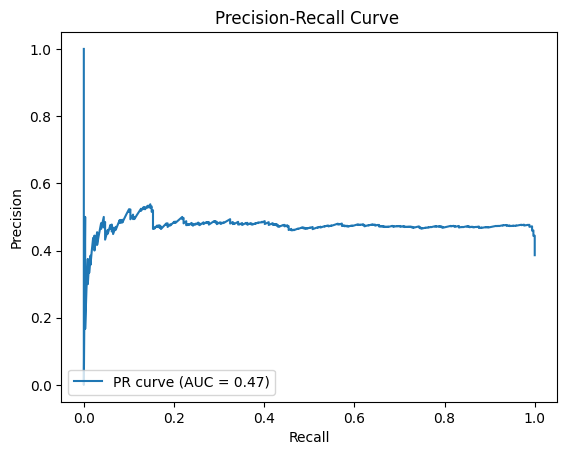

In [14]:
model.eval()
with torch.no_grad():
    X_test_tensor = X_test_tensor.to(device)
    y_test_tensor = y_test_tensor.to(device)

    # 予測と確率
    test_outputs = model(X_test_tensor).squeeze()
    predictions = (test_outputs >0.49).float()
    y_true = y_test_tensor.cpu().numpy()
    y_pred = predictions.cpu().numpy()
    y_prob = test_outputs.cpu().numpy()

# 評価指標
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    mcc = matthews_corrcoef(y_true, y_pred)
    specificity = recall_score(y_true, y_pred, pos_label=0)  
    print(f'Accuracy: {accuracy * 100:.2f}%')
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1 Score: {f1:.4f}')
    print(f'Matthews Correlation Coefficient: {mcc:.4f}')
    print(f'Specificity: {specificity:.4f}')

    # 混同行列（割合表示）
    cm = confusion_matrix(y_true, y_pred, normalize='true')
    sns.heatmap(cm, annot=True, fmt=".2%", cmap="Blues", cbar=False)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"Confusion Matrix (Normalized)")
    plt.show()

    # ROC曲線とAUC
    fpr, tpr, thresholds = roc_curve(y_true, y_prob)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--') 
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - Model ')
    plt.legend(loc="lower right")
    plt.show()

    # Precision-Recall曲線
    precision_curve, recall_curve, pr_thresholds = precision_recall_curve(y_true, y_prob)
    pr_auc = auc(recall_curve, precision_curve)
    plt.plot(recall_curve, precision_curve, label=f'PR curve (AUC = {pr_auc:.2f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Precision-Recall Curve ')
    plt.legend(loc="lower left")
    plt.show()    

In [15]:
# モデルと構造を保存
torch.save(model.state_dict(), '../../saved_model/DNN_11.pth')

